# Исследование надежности заемщиков

In [65]:
import pandas as pd
import seaborn
import matplotlib.pyplot as plt
import numpy as np

In [66]:
try:
    data = pd.read_csv('data.csv')
except:
    data = pd.read_csv('datasets/data.csv')

In [67]:
data.head(5)

,children,days_employed,dob_years,education,education_id,family_status,family_status_id,gender,income_type,debt,total_income,purpose
0,1,-8437.673028,42,высшее,0,женат / замужем,0,F,сотрудник,0,253875.639453,покупка жилья
1,1,-4024.803754,36,среднее,1,женат / замужем,0,F,сотрудник,0,112080.014102,приобретение автомобиля
2,0,-5623.422610,33,Среднее,1,женат / замужем,0,M,сотрудник,0,145885.952297,покупка жилья
3,3,-4124.747207,32,среднее,1,женат / замужем,0,M,сотрудник,0,267628.550329,дополнительное образование
4,0,340266.072047,53,среднее,1,гражданский брак,1,F,пенсионер,0,158616.077870,сыграть свадьбу


In [68]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21525 entries, 0 to 21524
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   children          21525 non-null  int64  
 1   days_employed     19351 non-null  float64
 2   dob_years         21525 non-null  int64  
 3   education         21525 non-null  object 
 4   education_id      21525 non-null  int64  
 5   family_status     21525 non-null  object 
 6   family_status_id  21525 non-null  int64  
 7   gender            21525 non-null  object 
 8   income_type       21525 non-null  object 
 9   debt              21525 non-null  int64  
 10  total_income      19351 non-null  float64
 11  purpose           21525 non-null  object 
dtypes: float64(2), int64(5), object(5)
memory usage: 2.0+ MB


В двух столбцах есть пропущенные значения. Один из них — `days_employed`. Пропуски в этом столбце будут обработаны на следующем этапе. Другой столбец с пропущенными значениями — `total_income` — хранит данные о доходах. На сумму дохода сильнее всего влияет тип занятости, поэтому заполнить пропуски в этом столбце нужно медианным значением по каждому типу из столбца `income_type`. Например, у человека с типом занятости `сотрудник` пропуск в столбце `total_income` должен быть заполнен медианным доходом среди всех записей с тем же типом.

In [69]:
data.isna().sum()

children               0
days_employed       2174
dob_years              0
education              0
education_id           0
family_status          0
family_status_id       0
gender                 0
income_type            0
debt                   0
total_income        2174
purpose                0
dtype: int64

In [70]:
for t in data['income_type'].unique():
    data.loc[(data['income_type'] == t) & (data['total_income'].isna()), 'total_income'] = \
    data.loc[(data['income_type'] == t), 'total_income'].median()

### Обработка аномальных значений

Отрицательное количество дней трудового стажа в столбце `days_employed` – это аномалия. Обработаем значения в этом столбце: замените все отрицательные значения положительными с помощью метода `abs()`.

In [71]:
data['days_employed'] = data['days_employed'].abs()

Для каждого типа занятости выведем медианное значение трудового стажа `days_employed` в днях.

In [72]:
data.groupby('income_type')['days_employed'].agg('median')

income_type
безработный        366413.652744
в декрете            3296.759962
госслужащий          2689.368353
компаньон            1547.382223
пенсионер          365213.306266
предприниматель       520.848083
сотрудник            1574.202821
студент               578.751554
Name: days_employed, dtype: float64

У двух типов (безработные и пенсионеры) аномально большие значения. Исправить такие значения сложно, оставим их как есть. Тем более этот столбец не понадобится нам для исследования.

Выведем перечень уникальных значений столбца `children`.

In [73]:
data['children'].unique()

array([ 1,  0,  3,  2, -1,  4, 20,  5])

В столбце `children` есть два аномальных значения. Удалим строки, в которых встречаются такие аномальные значения из датафрейма.

In [74]:
data = data[(data['children'] != -1) & (data['children'] != 20)]
data['children'].unique()

array([1, 0, 3, 2, 4, 5])

### Удаление пропусков (продолжение)

Заполним пропуски в столбце `days_employed` медианными значениями по каждого типа занятости `income_type`.

In [75]:
for t in data['income_type'].unique():
    data.loc[(data['income_type'] == t) & (data['days_employed'].isna()), 'days_employed'] = \
    data.loc[(data['income_type'] == t), 'days_employed'].median()

In [76]:
data.isna().sum().sum()

0

[Выделяют](https://loginom.ru/blog/missing) три механизма появления пропусков: *совершенно случаные* пропуски (missing completely at random), у которых равны вероятности возникновения; *случайные* (missing at random), которые по факту не совсем случайные, а возникшие ввиду какой-либо закономерности, которую можно описать, исходя из имеющегося набора данных; и *не случайные* (missing not at random) – те, что отсутвуют по неизвестным причинам (эти причины невозможно установить, исходя из имеющихся данных). В массиве с информацией по заемщикам пропуски есть в переменных `days_employed` (общий трудовой стаж в днях) и `total_income` (ежемесячный доход).

Пропущенные значение в переменных `days_employed` и `total_income` нельзя объяснить с помощью остальных переменных. Другими словами, нет никакой закономерности между пропусками в этих переменных и значениями других переменных. Единственная закономерность, которую удалось выявить – это взаимосвязь между пропусками в `days_employed` и в `total_income`. Те, кто не сообщил свой общий трудовой стаж в днях, также не указал ежемесячный доход. Таким образом, нельзя утверждать, что переменные были пропущены *совершенно случано* (completely at random). Также невозможно объяснить закономерность возникновения пропусков, исходя из данных в массиве (не получится объяснить пропуски через пропуски), поэтому ввозникновение пропусков нельзя назвать *случайным* (at random). Следовтаельно, данные были пропущены **не случайно** (not at random). У нас недостаточно данных, чтобы объяснить, почему появились пропуски в этих двух переменных. Это могла быть как техническая ошибка, возникшая при выгрузке данных, так и ошибка связанная с человеческим фактором (например, сотрудник банка не уточнил у этих клиентов общий трудовой стаж и ежемесячный доход).

### Изменение типов данных

Заменим вещественный тип данных в столбце `total_income` на целочисленный с помощью метода `astype()`.

In [77]:
data['total_income'] = data['total_income'].astype(int)

### Обработка дубликатов

Обработаем неявные дубликаты в столбце `education`. В этом столбце есть одни и те же значения, но записанные по-разному: с использованием заглавных и строчных букв. Приведем их к нижнему регистру. Проверим остальные столбцы.

In [78]:
data['education'] = data['education'].str.lower()

Выведем на экран количество строк-дубликатов в данных. Удалим их.

In [79]:
data.duplicated().sum()

71

In [80]:
data = data.drop_duplicates()

### Категоризация данных

На основании диапазонов, указанных ниже, создадим в датафрейме столбец `total_income_category` с категориями:

- 0–30000 — `'E'`
- 30001–50000 — `'D'`
- 50001–200000 — `'C'`
- 200001–1000000 — `'B'`
- 1000001 и выше (and above) — `'A'`

In [81]:
def categorize_income(income):
    try:
        if 0 <= income <= 30000:
            return 'E'
        elif 30001 <= income <= 50000:
            return 'D'
        elif 50001 <= income <= 200000:
            return 'C'
        elif 200001 <= income <= 1000000:
            return 'B'
        elif income >= 1000001:
            return 'A'
    except:
        pass

In [82]:
data['total_income_category'] = data['total_income'].apply(categorize_income)

Выведем на экран перечень уникальных целей взятия кредита из столбца `purpose`.

In [83]:
data['purpose'].unique()

array(['покупка жилья', 'приобретение автомобиля',
       'дополнительное образование', 'сыграть свадьбу',
       'операции с жильем', 'образование', 'на проведение свадьбы',
       'покупка жилья для семьи', 'покупка недвижимости',
       'покупка коммерческой недвижимости', 'покупка жилой недвижимости',
       'строительство собственной недвижимости', 'недвижимость',
       'строительство недвижимости', 'на покупку подержанного автомобиля',
       'на покупку своего автомобиля',
       'операции с коммерческой недвижимостью',
       'строительство жилой недвижимости', 'жилье',
       'операции со своей недвижимостью', 'автомобили',
       'заняться образованием', 'сделка с подержанным автомобилем',
       'получение образования', 'автомобиль', 'свадьба',
       'получение дополнительного образования', 'покупка своего жилья',
       'операции с недвижимостью', 'получение высшего образования',
       'свой автомобиль', 'сделка с автомобилем',
       'профильное образование', 'высшее об

Создадим функцию, которая на основании данных из столбца `purpose` сформирует новый столбец `purpose_category`, в который войдут следующие категории:

- `'операции с автомобилем'`, 
- `'операции с недвижимостью'`,
- `'проведение свадьбы'`,
- `'получение образования'`.

In [84]:
def categorize_purpose(row):
    try:
        if 'автом' in row:
            return 'операции с автомобилем'
        elif 'жил' in row or 'недвиж' in row:
            return 'операции с недвижимостью'
        elif 'свад' in row:
            return 'проведение свадьбы'
        elif 'образов' in row:
            return 'получение образования'
    except:
        return 'нет категории'

In [85]:
data['purpose_category'] = data['purpose'].apply(categorize_purpose)

### Исследовательский анализ данных

Для того, чтобы посмотреть на зависимость между количеством детей в семье и возвратом кредита в срок мы сгруппируем данные по количеству детей в семье и оценим долю должников в каждой группе. Для этого мы сгруппируем данные по переменной `children` и разделим количество должников на общее число людей в группе (поскольку переменная `debt` бинарная, мы можем оценить среднее в группе).

In [86]:
for children_num, debt in data.groupby('children')['debt']:
    print(f'Кол-во детей: {children_num}.') 
    print(f'Кол-во наблюдений в группе: {debt.count()}, доля должников: {debt.mean()}')
    print('**************')

Кол-во детей: 0.
Кол-во наблюдений в группе: 14091, доля должников: 0.07543822297920659
**************
Кол-во детей: 1.
Кол-во наблюдений в группе: 4808, доля должников: 0.09234608985024959
**************
Кол-во детей: 2.
Кол-во наблюдений в группе: 2052, доля должников: 0.09454191033138401
**************
Кол-во детей: 3.
Кол-во наблюдений в группе: 330, доля должников: 0.08181818181818182
**************
Кол-во детей: 4.
Кол-во наблюдений в группе: 41, доля должников: 0.0975609756097561
**************
Кол-во детей: 5.
Кол-во наблюдений в группе: 9, доля должников: 0.0
**************


Визуализируем данные для того, чтобы легче было сравнивать группы. Предварительно отсортируем группы в порядке убывания доли должников.

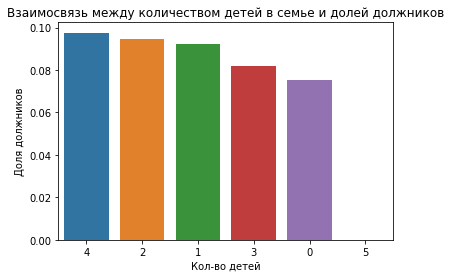

In [87]:
grouped_data = data.groupby('children')['debt'].mean()
grouped_data = grouped_data.sort_values(ascending=False).reset_index()
grouped_data['children'] = grouped_data['children'].astype('str')

seaborn.barplot(x=grouped_data['children'], y=grouped_data['debt'])
plt.xlabel('Кол-во детей')
plt.ylabel('Доля должников')
plt.title('Взаимосвязь между количеством детей в семье и долей должников')
plt.show()

Анализ графика показывает, что нет линейной взаимосвязи между количеством детей в семье и возвратом кредита в сорк.

Отметим, что в выборке представлено всего 9 семей, в которых воспитывается 5 детей. Такие данные могут быть нерепрезентативными. Для того, чтобы перепроверить полученные на предыдущем этапе результаты, мы можем категоризировать данные и посмотреть, как справляются с обязательствами по кредиту **многодетные** и **не многодетные семьи**. В России многодетной считается семья, в которой воспитываются три или более несовершеннолетних ребенка. Исходя из этого разделим выборку на основе значения переменной `children`.

In [88]:
def large_family(series):
    if series >= 3:
        return 'многодетная семья'
    else:
        return 'не многодетная семья'
    
data['children_status'] = data['children'].apply(large_family)

Посчитаем долю должников в группе многодетных и не многодетных семей.

In [89]:
for status, debt in data.groupby('children_status')['debt']:
    print(f'Статус семьи: {status}. Кол-во наблюдений: {debt.count()}, доля должников: {debt.mean()}')

Статус семьи: многодетная семья. Кол-во наблюдений: 380, доля должников: 0.08157894736842106
Статус семьи: не многодетная семья. Кол-во наблюдений: 20951, доля должников: 0.08118944203140661


Из полученных данных видно, что доли должников в рассматриваемых группах правктически одинаковые (разница составляет **0,04%**). Визуализируем данные, чтобы убедиться в этом.

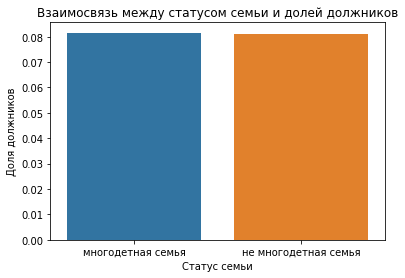

In [90]:
grouped_data = data.groupby('children_status')['debt'].mean()
grouped_data = grouped_data.sort_values(ascending=False).reset_index()

seaborn.barplot(x=grouped_data['children_status'], y=grouped_data['debt'])

plt.xlabel('Статус семьи')
plt.ylabel('Доля должников')
plt.title('Взаимосвязь между статусом семьи и долей должников')
plt.show()

**Вывод:** Не наблюдается зависимость между количеством детей в семье и возвратом кредитов в срок. Доли должников среди тех, у кого 1-2, 4 ребенка приблизительно равны (**9,2-9,8%**). Чуть меньше должников в семьях, где 3 ребенка (**8%**) и где нет детей вообще (**7,5%**). В семьях, где проживает 5 детей, доля должников в этой выборке составила **0%**. Рассмотрев данных по категориям среди **многодетных** и **не многодетных** мы убедились в отсутсвии зависимости между количеством детей в семье и возвратом кредита.

Чтобы посмотреть на зависимость между семейным положением и возвратом кредита в срок, мы сгрупируем данные по семейному статусу и оценим долю должников в гаждой группе. Для группировки данных мы будем использовать переменную `family_status`, для определения доли должников мы, как и на предыдущем шаге, оценим среднее значение переменной `debt` в группах.

In [91]:
# Ваш код будет здесь. Вы можете создавать новые ячейки.
data['family_status'] = data['family_status'].str.lower() # приведем все название категорий к одному регистру

for marital_status, debt in data.groupby('family_status')['debt']:
    print(f'Семейное положение: {marital_status}.')
    print(f'Кол-во наблюдений: {debt.count()}, доля должников: {debt.mean()}')
    print('**************')

Семейное положение: в разводе.
Кол-во наблюдений: 1189, доля должников: 0.07064760302775441
**************
Семейное положение: вдовец / вдова.
Кол-во наблюдений: 951, доля должников: 0.06624605678233439
**************
Семейное положение: гражданский брак.
Кол-во наблюдений: 4134, доля должников: 0.09313014029995162
**************
Семейное положение: женат / замужем.
Кол-во наблюдений: 12261, доля должников: 0.07560557866405676
**************
Семейное положение: не женат / не замужем.
Кол-во наблюдений: 2796, доля должников: 0.09763948497854077
**************


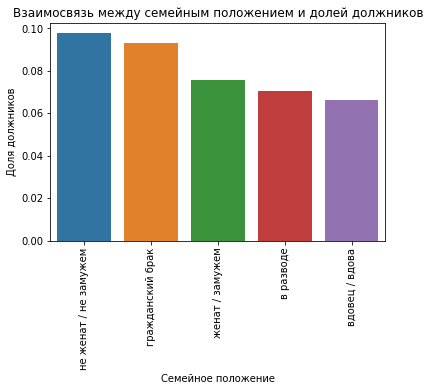

In [92]:
grouped_data = data.groupby('family_status')['debt'].mean()
grouped_data = grouped_data.sort_values(ascending=False).reset_index()

seaborn.barplot(x=grouped_data['family_status'], y=grouped_data['debt'])

plt.xticks(rotation=90)
plt.xlabel('Семейное положение')
plt.ylabel('Доля должников')
plt.title('Взаимосвязь между семейным положением и долей должников')
plt.show()

Среди тех, кто не состоял в браке в принципе, больше всего должников. Но вдовцы и разведенные (т.е. те, кто уже не в браке) лучше справляются с обязательствами по кредиту, чем те, кто состоит в официальном или гражданском браке. На данном этапе не ясно, есть ли взаимосвязь между семейным положением и возвратом кредита.

**Вывод:** Больше всего должников среди тех, кто изначально был отнесен в категорию "не женат / не замужем" (**9,76%**). На втором месте – должники из тех, кто состоит в граждансом браке (**9,3%**). Те, кто состит в браке или находится в разводе практически одинаково справляются с обязательствами по кредиту – доля должников в этих группах состявляет **7,6%** и **7%** соотвественно. Меньше всего должников среди вдовцов (6,6%). Нет явной взаимосвязи между семейным положением и возвратом кредита. Нельзя выявить единый тренд для людей, не состоящих в браке по разным причинам (вдовцов, разведенных, незамужних/неженатых).

Для того, чтобы проверить, есть ли взаимосвязь между уровнем дохода и возвратом кредита в срок, мы разделим выборку на группы в соответсвии с категиориями дохода и посчитаем долю должников в каждой из групп. Для этого на этапе предобработки мы сгрупировали данные по значениям переменной `total_income`. Всего в ходе анализа было выделеной пять категорий дохода: 

- 0–30000 — `'E'`;
- 30001–50000 — `'D'`;
- 50001–200000 — `'C'`;
- 200001–1000000 — `'B'`;
- 1000001 и выше — `'A'`.

Далее мы оценим среднее значение переменной `debt` в каждой группе, чтобы выявить долю тех, у кого есть или были задолженности по кредитам.

In [93]:
# Ваш код будет здесь. Вы можете создавать новые ячейки.
for income_cat, debt in data.groupby('total_income_category')['debt']:
    print(f'Уровень дохода: {income_cat}')
    print(f'Кол-во наблюдений: {debt.count()}, доля должников: {debt.mean()}')
    print('**************')

Уровень дохода: A
Кол-во наблюдений: 25, доля должников: 0.08
**************
Уровень дохода: B
Кол-во наблюдений: 5014, доля должников: 0.07060231352213801
**************
Уровень дохода: C
Кол-во наблюдений: 15921, доля должников: 0.08498209911437724
**************
Уровень дохода: D
Кол-во наблюдений: 349, доля должников: 0.06017191977077364
**************
Уровень дохода: E
Кол-во наблюдений: 22, доля должников: 0.09090909090909091
**************


Визуализируем данные, отсортировав их в порядке убывания.

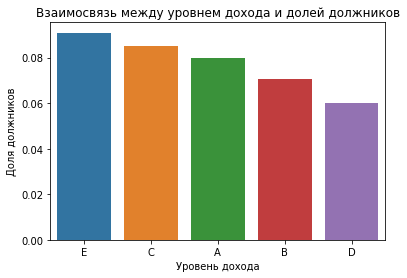

In [94]:
grouped_data = data.groupby('total_income_category')['debt'].mean()
grouped_data = grouped_data.sort_values(ascending=False).reset_index()

seaborn.barplot(x=grouped_data['total_income_category'], y=grouped_data['debt'])

plt.xlabel('Уровень дохода')
plt.ylabel('Доля должников')
plt.title('Взаимосвязь между уровнем дохода и долей должников')
plt.show()

**Вывод:** Больше всего должников (**9%**) среди тех, чей доход не превышает 30 тыс. руб (категория E). При этом люди со средним доходом (30-50 тыс. руб), которые были отнесены к категории D, лучше остальных выполняют обязательства по кредитам. Доля должников среди них – **6%**. Люди с доходом более 50 тыс. рублей хуже, чем "средний класс" (категория D) выплачивают кредиты: доля должников среди тех, кто вошел в категорию A, B или C, составила от **7%** до **8,5%**. 

Чтобы определить, как цель кредита влияет на его возврат, мы разделим данные на группы в зависимости от цели, на которую был выдан кредит. Затем в каждой группе мы посчитаем долю тех, у кого были задолженности по кредитам. Так мы определим, какие кредиты обычно возвращаются в срок, а по каким чаще бывают задолженности. Для того, чтобы сгруппировать данные, мы обратимся к переменной `purpose_category`, которая указывает, с какой целью был выдан кредит. Всего в массиве данных удалось выделить 4 цели, на которые берут кредит:

- `'операции с автомобилем'`,
- `'операции с недвижимостью'`,
- `'проведение свадьбы'`,
- `'получение образования'`.

В сформированных группах мы оценим долю должников, посчитав среднее значение переменной `debt` в каждой группе. Ниже представлены результаты расчетов.

In [95]:
# Ваш код будет здесь. Вы можете создавать новые ячейки.
for purpose, debt in data.groupby('purpose_category')['debt']:
    print(f'Цель кредита: {purpose}')
    print(f'Кол-во наблюдений: {debt.count()}, доля должников: {debt.mean()}')
    print('**************')

Цель кредита: операции с автомобилем
Кол-во наблюдений: 4279, доля должников: 0.09347978499649451
**************
Цель кредита: операции с недвижимостью
Кол-во наблюдений: 10751, доля должников: 0.07255139056831923
**************
Цель кредита: получение образования
Кол-во наблюдений: 3988, доля должников: 0.09252758274824474
**************
Цель кредита: проведение свадьбы
Кол-во наблюдений: 2313, доля должников: 0.07911802853437094
**************


Визуализируем полученные данные, отсортировав их по убыванию.

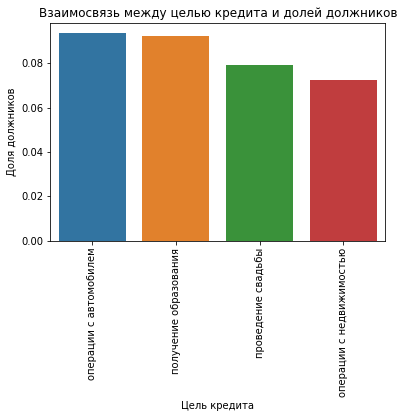

In [96]:
grouped_data = data.groupby('purpose_category')['debt'].mean()
grouped_data = grouped_data.sort_values(ascending=False).reset_index()

seaborn.barplot(x=grouped_data['purpose_category'], y=grouped_data['debt'])

plt.xticks(rotation=90)
plt.xlabel('Цель кредита')
plt.ylabel('Доля должников')
plt.title('Взаимосвязь между целью кредита и долей должников')
plt.show()

**Вывод:** Меньше всего должников (**7,26%**) среди тех, кто брал ипотеку или иной кредит с целью проведения операций с недвижимостью. Чуть больше доля должников (**7,9%**) среди тех, кто брал кредит на свальбу. Самый большой процент среди должников – это студенты, родители студентов, – все те, кто брал кредит на получение образования (**9,25%**). Покупка, продажа и проч. операции с автомобилями – **9,3%** тех, кто взял кредит с этой целью, имеют/имели задолженность по нему.

### Вывод

**Предобработка данных:**
* На этапе изучения данных были выявлены пропуски в значениях переменных `days_employed` и `total_income`. Поскольку ежемесячный доход (`total_income`) сильно зависит от типа занятости для замены пропусков лучше использовать медианное значение. При изучении переменной "трудовой стаж в днях" (`days_employed`) были обнаружены выбросы – аномальные значения для *пенсионеров* и *безработных*. Из-за выбросов для замены пропусков в переменной "трудовой стаж" мы также используем медиану.
* В данных также были выявлены аномальные значения. Отрицательные значения для переменной `days_employed` мы заменили на модуль этих значений, а наблюдения с аномальными значениями переменной `children` удалили.
* Для переменной `total_income` потребовалось изменить тип данный с вещественного на целочисленный.
* Мы также удалили явные дубликаты в данных.
* На последнем этапе предобработки мы категоризировали переменную `total_income`, создав категории дохода A-E, и переменную `purpose`, разделив цели кредита на 1) операции с недвижимостью, 2) операции с автомобилем, 3) свадьба, 4) образование.

**Результаты анализа данных:**
* По результатам анализа данных не была выявлена линейная взаимосвязь между количеством детей и возвратом кредита в срок: многодетные и не многодетные семьи справляются с кредитными обязательствами одинаково. 
* Тот факт, состоит ли человек в браке или нет не взаимосвязан с наличием задолженности по кредиту. Интересно, что лучше всех выплачивают кредиты вдовцы, а хуже всех – те, кто не состоит в браке. Есть предположение, что эта взаимосвязь обусловлена другой переменной, например, возрастом.
* Предположительно, между уровнем дохода и возвратом кредита в срок существует квадратичная (U-образная) взаимосвязь: больше всего должников среди тех, чей доход не превышает 30 тыс., средний класс (30-50 тыс. руб.) справляется лучше всех с обязательствами по кредитам, а среди людей, с достатком выше среднего (от 50 тыс. руб.) – много должников. 
* Предположительно, между целью кредита и его возвратов в срок существует взаимосвязь. Лучше всего выплачивают кредит те, кто брал его на операции с недвижимостью. Хуже всех справляются с кредитами автомобилисты и студенты.